# Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech

Official implementation of the Grad-TTS model based on Diffusion Probabilistic Models. For all details check out our paper accepted to ICML 2021 via [this](https://arxiv.org/abs/2105.06337) link.

You can listen to the samples on our demo page via [this](https://grad-tts.github.io/) link.

You can access Google Colab demo notebook via [this](https://colab.research.google.com/drive/1YNrXtkJQKcYDmIYJeyX8s5eXxB4zgpZI?usp=sharing) link.

**Authors**: Vadim Popov\*, Ivan Vovk\*, Vladimir Gogoryan, Tasnima Sadekova, Mikhail Kudinov.

<sup>\*Equal contribution.</sup>

**Note**: for fast synthesis prefer running inference on GPU device.

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import argparse
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

import torch

# For Grad-TTS
import params
from model import GradTTS
from text import text_to_sequence, bndict
from text.symbols import symbols
from utils import intersperse

# For HiFi-GAN
import sys
sys.path.append('./hifi-gan/')
from env import AttrDict
from models import Generator as HiFiGAN

/media/SSD/tungtk2/t2s_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
N_SPKS = 1  # 247 for Libri-TTS model and 1 for single speaker (LJSpeech)

In [4]:
generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim,
                    params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
                    pe_scale=1000)  # pe_scale=1 for `grad-tts-old.pt`
# chkt_path = './logs/exp1/grad_2697.pt'
# chkt_path = './logs/internal_exp/grad_2500.pt'
chkt_path = './logs/bahnar_exp/grad_1344.pt'

generator.load_state_dict(torch.load(chkt_path, map_location=lambda loc, storage: loc))
_ = generator.eval()
print(f'Number of parameters: {generator.nparams}')

cmu = bndict.BNDict('./data/bahnar_lexicon.txt')

/media/SSD/tungtk2/t2s_env/lib/python3.8/site-packages/torch/cuda/__init__.py:106: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


Number of parameters: 14827736


In [7]:
with open('./checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h)
hifigan.load_state_dict(torch.load('./checkpts/hifigan.pt', map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.eval()
hifigan.remove_weight_norm()
%matplotlib inline

Removing weight norm...


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
text = "trong glong tôjroh ameêm teh ñak"

In [ ]:
x = torch.LongTensor(intersperse(text_to_sequence(text, dictionary=cmu), len(symbols)))[None]
x_lengths = torch.LongTensor([x.shape[-1]])
x.shape, x_lengths, x

(torch.Size([1, 65]),
 tensor([65], device='cuda:0'),
 tensor([[110,  77, 110,  75, 110,  55, 110,  54, 110,  42, 110,   2, 110,  42,
          110,  52, 110,  55, 110,  54, 110,  42, 110,   2, 110,  77, 110,  61,
          110,  50, 110,  75, 110,  55, 110,  43, 110,   2, 110,   7, 110,  53,
          110,  29, 110,  35, 110,  53, 110,   2, 110,  77, 110,  29, 110,  43,
          110,   2, 110, 104, 110,   7, 110,  51, 110]], device='cuda:0'))

Grad-TTS RTF: 0.34646904341063345


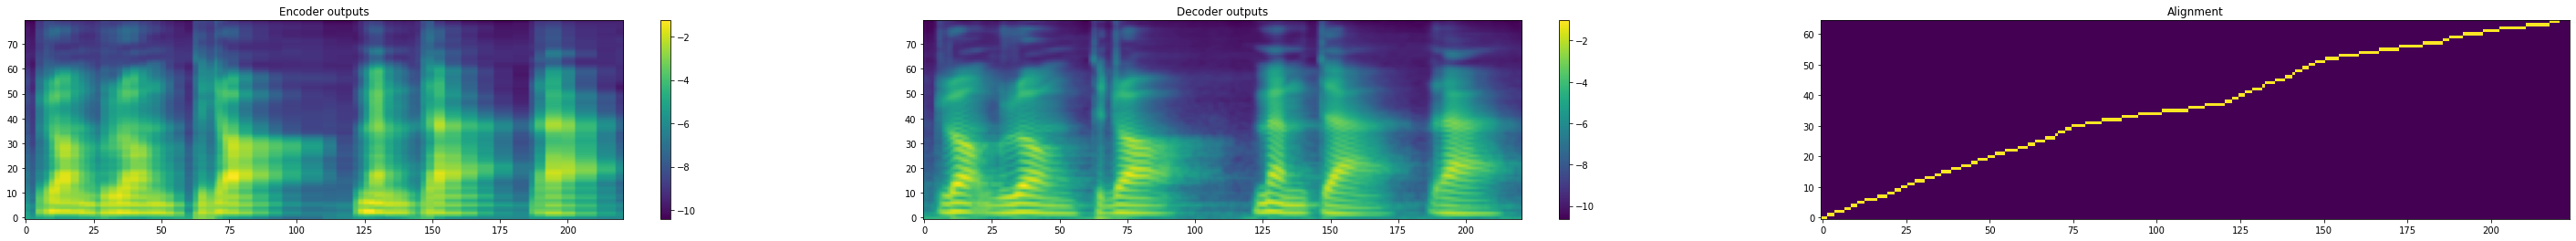

In [ ]:
t = dt.datetime.now()
y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=50, temperature=1.3,
                                       stoc=False, spk=None if N_SPKS==1 else torch.LongTensor([15]),
                                       length_scale=0.91)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * 22050 / (y_dec.shape[-1] * 256)}')

plt.figure(figsize=(50, 4))
plt.subplot(1, 3, 1)
plt.title('Encoder outputs')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('Decoder outputs')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('Alignment')
plt.imshow(attn.cpu().squeeze(), aspect='auto', origin='lower');

In [6]:
with torch.no_grad():
    audio = hifigan.forward(y_dec).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=22050))

NameError: name 'y_dec' is not defined

In [42]:
gt_path = 'data/bahnar/TTS/Kinh tế-Xã hội/03/B-Dữ liệu đã xữ lý/Âm thanh Nam/0016.2.wav'

ipd.display(ipd.Audio(gt_path, rate=22050))

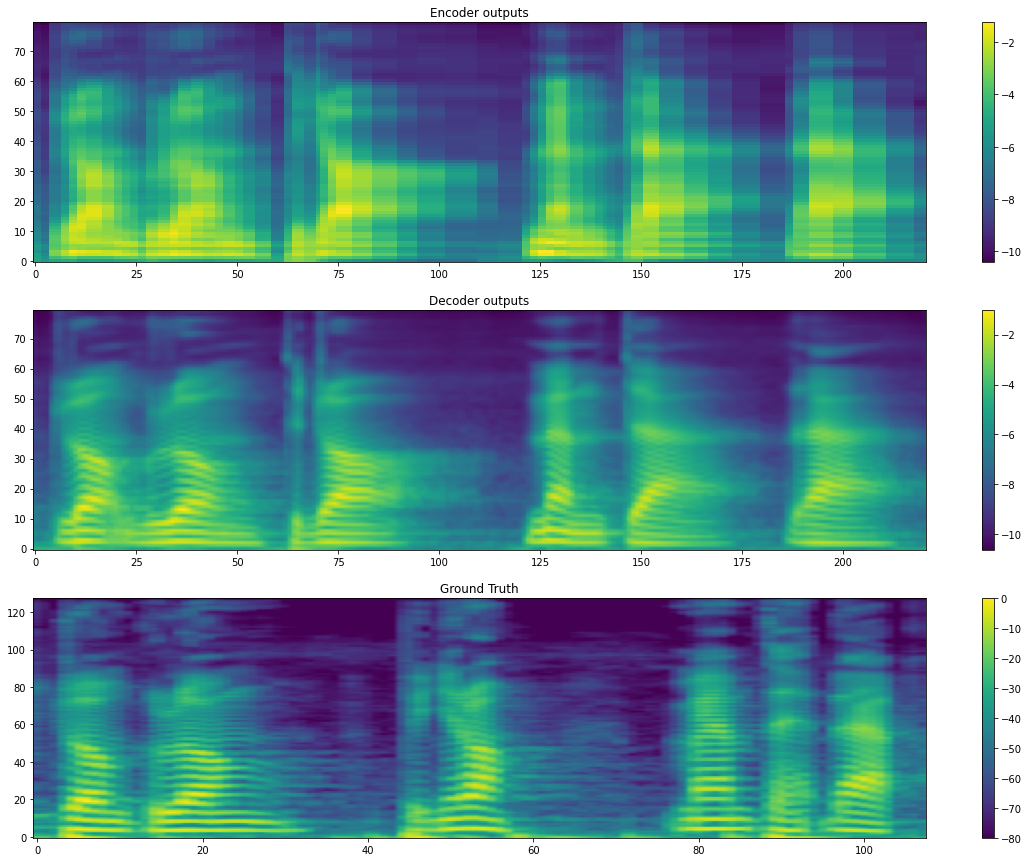

In [43]:
import librosa
import librosa.display


y, sr = librosa.load(gt_path, sr=22050)

gt_mel = librosa.feature.melspectrogram(y=y, sr=sr)
gt_mel = librosa.power_to_db(gt_mel, ref=np.max)

plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
plt.title('Encoder outputs')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(3, 1, 2)
plt.title('Decoder outputs')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(3, 1, 3)
plt.title('Ground Truth')
plt.imshow(gt_mel, aspect='auto', origin='lower')
plt.colorbar()


In [30]:
from scipy.io.wavfile import write, read
import os

In [16]:
with open('resources/filelists/eval.txt', 'r', encoding='utf-8') as f:
    tups = [line.strip().split('|') for line in f.readlines()]
#     gt_audios = [line.strip()[:line.strip().find('|')] for line in f.readlines()]

In [22]:
gt_audios, texts = list(zip(*tups))

In [31]:
for i, gt_audio in enumerate(gt_audios):
    sr, audio = read(gt_audio)

    dir = f'eval/q{i+1}'
    if not os.path.exists(dir):
        os.makedirs(dir)
    write(f'{dir}/test1.wav', sr, audio)

In [42]:
for i, text in enumerate(texts):
    x = torch.LongTensor(intersperse(text_to_sequence(text, dictionary=cmu), len(symbols)))[None]
    x_lengths = torch.LongTensor([x.shape[-1]])
    
    y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=50, temperature=1.3,
                                           stoc=False, spk=None if N_SPKS==1 else torch.LongTensor([15]),
                                           length_scale=0.91)
    dir = f'eval/q{i+1}'
    if not os.path.exists(dir):
        os.makedirs(dir)

#     with torch.no_grad():
#         audio = (hifigan.forward(y_enc).cpu().squeeze().clamp(-1, 1).numpy() * 32_768).astype(np.int16)

#     write(f'{dir}/test2.wav', 22050, audio)


    with torch.no_grad():
        audio = (hifigan.forward(y_dec).cpu().squeeze().clamp(-1, 1).numpy() * 32_768).astype(np.int16)

    write(f'{dir}/test4.wav', 22050, audio)